# COMP-4360 - Machine Learning - Assignment 1 - Project

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|6 October 2022  | **23 October 2022** |



Student ID: ** 7871652 **  

Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations for models and algorithms), what the results mean, how they relate to the theory, etc. For learning jupyter notebooks, you may refer to this guide: https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively, these are individual exercises. The notebook you write should be about the results you obtained, and your attention is drawn to the University guidelines on collaboration and plagiarism. 

## Project specification

Implement a standard echo state network (ESN) model as discussed in class. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# make sure plots are correctly displayed in the notebook
%matplotlib inline

### ESN Model With No Feedback

We define an ESN class that does not accept feedback.

The constructor of this ESN class accept:
- The reservoir size $N_r$
- A random seed (integer) to generate random numbers
- A scalar a that is used to scale the spectral radius
- A regularization coefficient reg_cof

#### The ESN model is defined as below:

$x_t = \phi(\boldsymbol{W^r} x_{t-1} + \boldsymbol{W^i} u_t)$


$z_t = \boldsymbol{W^o} x_t$


where x_t, u_t, z_t are states, inputs and output at discrete time step t respectively.

#### Parameters:

- $\boldsymbol{W^r}$: Recurrent layer weight matrix. 
  - $\boldsymbol{W^r}\in\mathbb{R}^{N_r * N_r}$, where $N_r$ is the number of neurons in the reservoir.

- $\boldsymbol{W^i}$: Input-to-reservoir weight matrix. 
  - $\boldsymbol{W^i}\in\mathbb{R}^{N_r * N_i}$, where $N_i$ is the input dimension.

- $\boldsymbol{W^o}$: read-output weight matrix.
  - $\boldsymbol{W^i}\in\mathbb{R}^{N_o * N_r}$, where $N_o$ is the output dimension.

When an ESN model instance is initialized, it does the following steps

- 1. Initialize model parameters $\boldsymbol{W^i}$ and $\boldsymbol{W^r}$ using the following rules:
  - Elements of $\boldsymbol{W^i}$ and $\boldsymbol{W^r}$ are indepndently drawn from a uniform distribution $[-1, 1]$
  - Find the spectral radius of $\boldsymbol{W^r}$, denoted as $p( \boldsymbol{W^r} )$. Then update $\boldsymbol{W^r}$ as: $\boldsymbol{W^r}$ = $a\frac{ \boldsymbol{W^r} }{ p( \boldsymbol{W^r} ) }$

- 2. Initialize the first state $x_0 = 0$
    
- 3. Feed the network with the sequence of input $u_i, i = 1, ..., N$


- 4. Collect the resulting N stages $x_i$ in a matrix $X \in \mathbb{R}^{N * N_r}$ 


- 5. Store all related targets in a $N-dimensional$ vector $t \in \mathbb{R}^{N}


- 6. Find  $\boldsymbol{W^o}$ by solving the regularized least-square problem

### Regularized least-square problem for $W_o$

The problem is represented as: 

- $\underbrace{arg\_min}_{\boldsymbol{W}\in\mathbb{R}^{N_r * N_o}}\frac{1}{2}\parallel$XW - t$\parallel^{2} + \frac{\lambda}{2}\parallel$W$\parallel^{2}$ 

which have closed form solution:



- $W = (X^{T}X + \lambda I)^{-1} X^{T}t$

In [25]:
class ESN:

    '''
        n_reservoirs = 300        # Number of reservoir neurons     
        seed = 1                # Random seed
        g = 0.5                 # g to control deviation
        a = 0.98                # a to scale with spectral radius
        input_dim = 1           # input dimension
        reg_cof = 1e-7          # Regularization coefficient

        x = 0                   # initialize x to be all zeros
        W_i = 0                 # Weight of input
        W_r = 0                 # Weight of reservoir
        W_o = 0                 # Weight of output
    '''
    # Constructor
    def __init__(self, reservoir_size, input_dim, random_seed, a, reg_cof):
        self.n_reservoirs = reservoir_size
        self.input_dim = input_dim
        self.seed = random_seed
        #self.g = g 
        self.reg_cof = reg_cof
        self.a = a

        self.x = np.zeros((self.n_reservoirs, 1), dtype = float)
        self.W_o = 0

        # Initialize W_i  and W_r as discussed above
        np.random.seed(self.seed)
        #self.W_i = np.random.uniform( -1, 1,(self.n_reservoirs, self.input_dim) )
        #self.W_r = np.random.uniform( -1, 1, (self.n_reservoirs, self.n_reservoirs))
        self.W_i = np.random.rand(self.n_reservoirs, self.input_dim) - 0.5
        self.W_r = np.random.rand(self.n_reservoirs, self.n_reservoirs) - 0.5
        
        spectral_rad = max(abs(np.linalg.eig(self.W_r)[0]))

        self.W_r *= a/spectral_rad
        self.spectral_rad = max(abs(np.linalg.eig(self.W_r)[0]))
        #print("spectral rad is:  ", spectral_rad)
    '''
---- Model computation from here ----
    '''

    # fit() receive the training data and train W_r to best fit the training data
    def fit(self, input_set, target_set):
        
        self.W_o = self.weight_output_optimize(input_set, target_set)
        #return self.W_o
    
    # predict() accept the input and predict 0 step ahead (k = 0)
    def predict(self, input_data):

        input_size = len(input_data)

        X = self.state_computation(input_data, continue_state = True)
        Z = np.empty( (input_size, 1), dtype = float)

        for t in range( input_size ):
            x = X[t,:].T                    # State at time t
            Z[t,0] = np.dot( self.W_o, x )   # Predicted value

        return Z

    '''
---- Helper functions from here ----
    '''

    ## Train W_o using ridge regression
    def weight_output_optimize(self, input_set, target):


        # Get the collection of states from the reservoir
        X = self.state_computation(input_set, continue_state = False)
        #print("Shape of X: ", np.shape(X))
        X_T = X.T       # Taking transpose

        # The target is used to compared with the prediction
        #print("Shape of target: ", np.shape(target))
        # Then use ridge regression to optimize output wight W_out
        W_out = np.dot( \
                np.dot(\
                np.linalg.inv( np.dot(X_T, X) + self.reg_cof*np.eye(self.n_reservoirs) ), X_T)\
                , target).T 
        #print("Shape of W_out: ", np.shape(W_out))
        return W_out

    ## Run the reservoir with the data and collect the states into X
    def state_computation(self, input_set, continue_state):

        input_size = len(input_set)
        #print("In state compute, input size is ", input_size)

        # X hold the states from the reservoir after each time t
        X = np.empty( (input_size, self.n_reservoirs), dtype = float)

        # x is the result compute from the reservoir at time t
        if not continue_state:
            #print("in state compute, not continue state")
            self.x = np.zeros((self.n_reservoirs, 1), dtype = float)

        # Computing states at each time t, then colect them to X
        for t in range(input_size):

            u = input_set[t]  
            self.x = np.tanh( np.dot( self.W_i, u ) + np.dot( self.W_r, self.x ) )
            X[t,:] = self.x[:,0]
        return X

2 helper functions to help with testing our model

- split_data_by_k_step(data, k) split the data into input_data and output_data such that input_data[i] and output_data[i] vary by a time step split_data_by_k_step k 

- mse_nrrmse(target, predict) return mse and nrmse between target and predict data set

#### MSE and MRSE formular
$MSE = <\parallel t - z \parallel^{2}>$, where <.> indicates average over time, t and z are target and predicted value respectively.

$NRMSE = \frac{\sqrt{MSE}}{var(t)}$


In [26]:
def split_data_by_k_step(data, k):

    '''
    Function to split a given data depends on the given step k
    Return a pair of input_data and target_data where input_data[i] and target_data[i] vary by time k

    Args:
        data: ndarray of size n_observation x nr_input_dimension
        k: (integer) - time vary between the input and the expected output
    
    Returns:
        input_set: an ndaray of size [len(data) - k ] x nr_input_dimension
        output_set: an ndaray of size [len(data) - k ] x nr_input_dimension
    '''

    # Input_set[i] and output_set[i] varies by a time k
    input_set = data[None, 0:(len(data)-k)].T
    output_set = data[None, k:(len(data))].T

    return input_set, output_set

def mse_nrmse(target, predict):

    '''
    calculate mean squared erroe (MSE) and normal_rooted mean squared error
    
    Args:
        target: [n_inputs x n_features]-ndaray. 
        predict: [n_inputs x n_features]-ndaray.
    
    Returns:
        mean squared error (mse) between target and predict
        normal root mean squared error (nrmse) between target and predict
    '''

    mse = sum( np.square( target - predict ) ) 
    nrmse = np.sqrt(mse)/(np.var(target, ddof = 1))
    
    return mse, nrmse

def model_report(model):
    print()
    print('Model report')
    print('Number of res: ', model.n_reservoirs)
    print('Random seed: ', model.seed)
    print('a: ', model.a)
    print('reg_cof: ', model.reg_cof)
    print('x: ', model.x)
    print('spectral_rad :', model.spectral_rad)
  

This function accept an ESN instance, the data given to train, the k-time step and a ratio to decide how many data to use for training and testing. It then do the split of the data, run the fit() function of the model, the run the predict() function on the given test input and obtain the predicted result.

In [27]:
def predict_k_step(model, data, k, training_part):

    '''
    
    Args:
        model: an ESN instance
        data: [n_observation x n_features] ndaray, data use to train and test the model
        k: number of time step this model is train to predict
        training_part: a float that is in range (0, 1). 
    
    Returns:
        nrmse: The normal root mean-squared error of the model after testing
        z: [1 x n_features] - The predicted values after testing
        target: The target values the model try to predict
        training_len + 1: The time (i.e. position in the data) at which the model starts performing prediction
    '''

    # Split data to input and output, 
    # where the output at position i is k time away from the input at position i
    training_input, training_output = split_data_by_k_step(data, k)

    # Training length is decided by the training_part ratio
    training_len = int( training_part * len(training_input) )

    # Test input and target is taken from position training_len to the end
    test_input = training_input[training_len:, 0]
    target = training_output[training_len:, 0]

    # Use the part from 0 to (training_len-1) of the input and output to train the model
    model.fit(training_input[0:training_len, 0],  training_output[0:training_len, 0])

    # Perform prediction after training
    z = model.predict(test_input)

    mse, nrmse = mse_nrmse(z[:, 0], target)

    return nrmse, z, target, training_len + 1


Helper function to plot several plots of predicted and target value with different time step k

In [28]:
def plot_result(prediction, target, time_start, nrmse, list_of_step_k, name_of_data):

    for i in range(len(prediction)):

        plt.figure(i, figsize = (15, 3))
        plt.figure(i).clear()
        plt.plot( range(time_start, time_start + len(prediction[i])), target[i], 'b' )
        plt.plot( range(time_start, time_start + len(prediction[i])), prediction[i], 'r' )   
        title = 'Target and predicted signals at k = ' + str(list_of_step_k[i]) + ' for ' + name_of_data
        plt.title(title)
        plt.xlabel('t')
        plt.legend(['Targeted signal', 'Predicted Signal'])

    plt.figure(len(prediction) + 1, figsize = (15, 3))
    plt.figure(len(prediction) + 1).clear()
    plt.plot( list_of_step_k, nrmse, 'g' )
    plt.title('Loss')
    plt.xlabel('Number of step k')
    plt.ylabel('Loss (NRMSE)')

We first try to predict 2sin and lorentz with the hyper-parameters below
- $reservoir\_size$ = 500
- $reg\_cof = 0.001$
- $a = 1.26$
- $seed = 33$
- $k \in \{0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100\}$
- training_input = 70% total input

Computing model for 2sin with k =  0
Computing model for 2sin with k =  10
Computing model for 2sin with k =  20
Computing model for 2sin with k =  30
Computing model for 2sin with k =  40
Computing model for 2sin with k =  50
Computing model for 2sin with k =  60
Computing model for 2sin with k =  70
Computing model for 2sin with k =  80
Computing model for 2sin with k =  90
Computing model for 2sin with k =  100


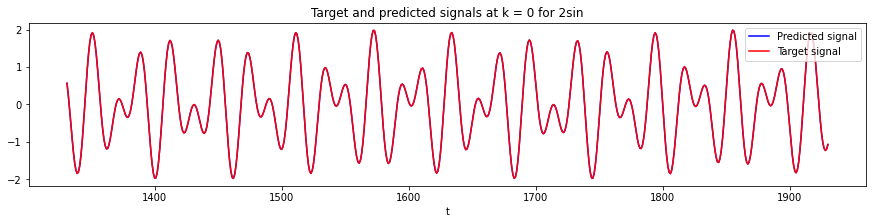

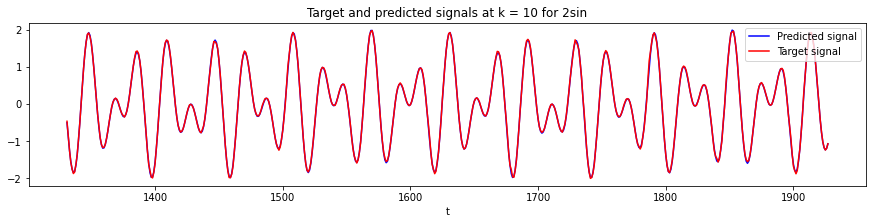

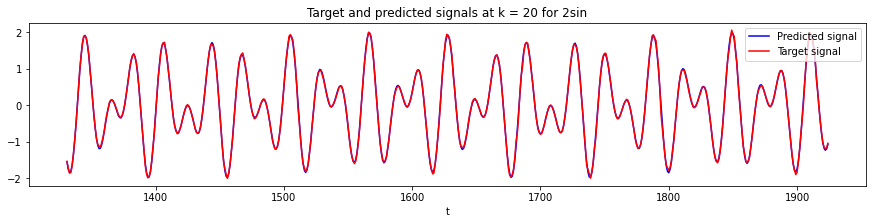

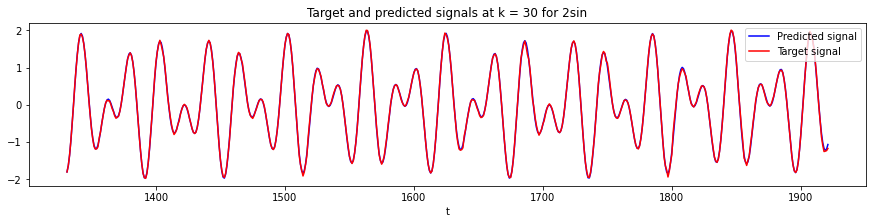

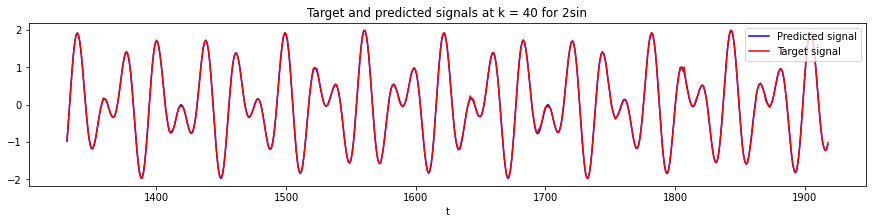

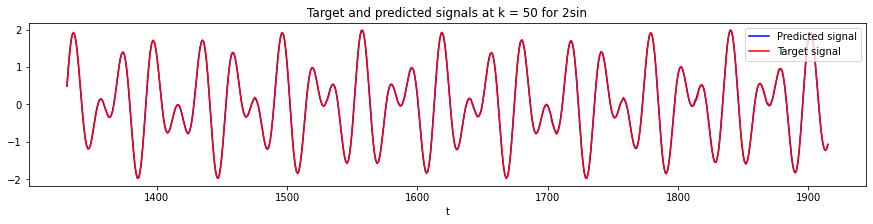

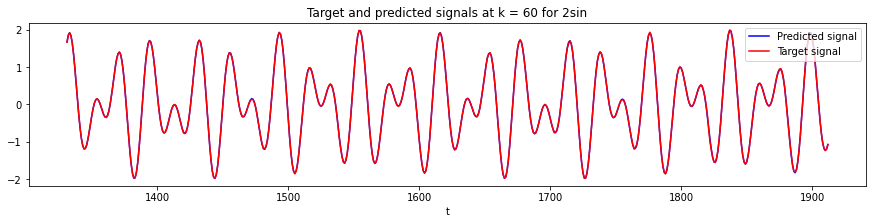

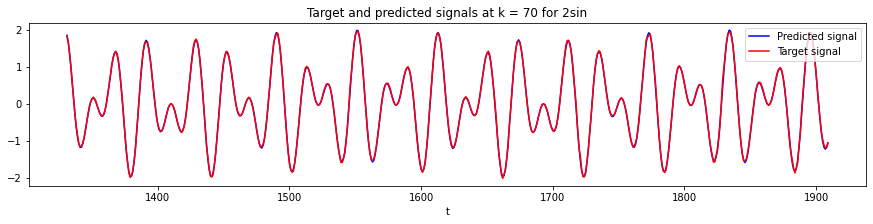

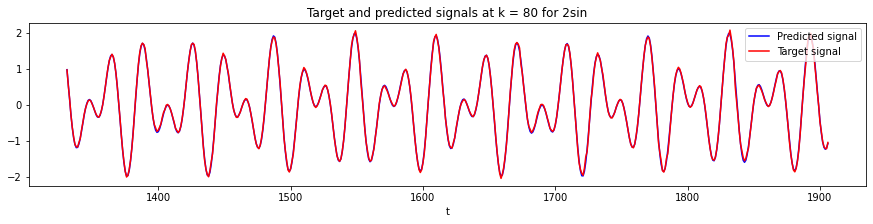

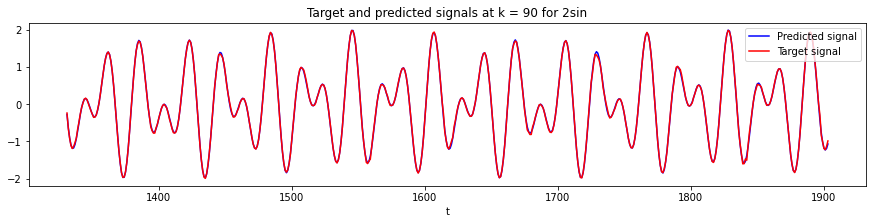

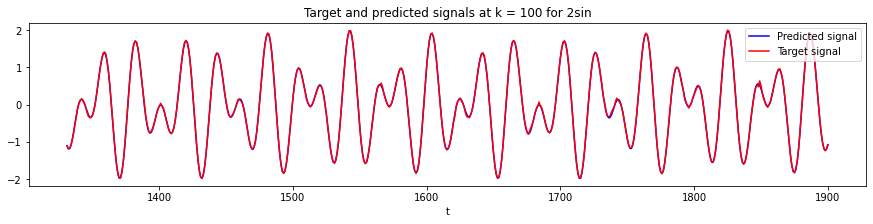

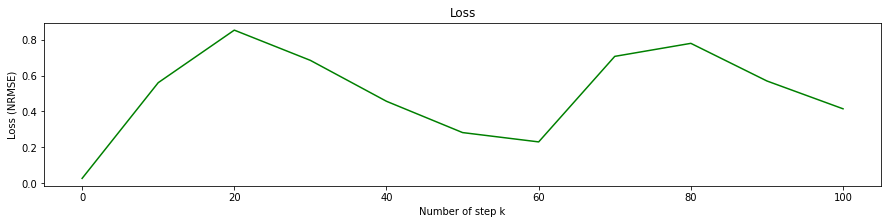

In [29]:

'''
Test our model on the 2sin data
'''

# Load the datas
data1 = np.loadtxt('2sin.txt')
data2 = np.loadtxt('lorenz.txt')

k_max = 100
step = 10
length = int(k_max/step + 1)    
training_part = 0.7             # 70% of input is used to train

list_of_step_k = range(0, k_max+1, step)

nrmse_result = [None] * length
z_result =  [None] * length
target_result =  [None] * length
time_start = 0

# Initialize an ESN model instance
model = ESN(reservoir_size = 500, input_dim = 1, random_seed = 33, a = 1.26, reg_cof = 1e-3)

# Run the model with different k for 2sin data, and collect results
for i in range(length):

    print('Computing model for 2sin with k = ', list_of_step_k[i])

    nrmse_result[i], z_result[i], target_result[i], time_start = predict_k_step(model, data1,\
                                                                                list_of_step_k[i],\
                                                                                training_part)

# plot some signals
plot_result(z_result, target_result, time_start, nrmse_result, list_of_step_k, '2sin')



The model predict 2sin very well with only reservoir size 500, and can even predict to k = 100. 

Computing model  0
Computing model  1
Computing model  2
Computing model  3
Computing model  4
Computing model  5
Computing model  6
Computing model  7
Computing model  8
Computing model  9
Computing model  10


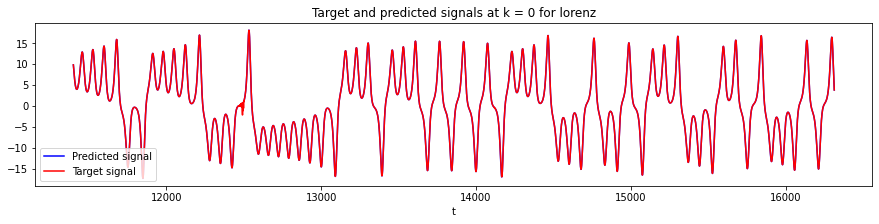

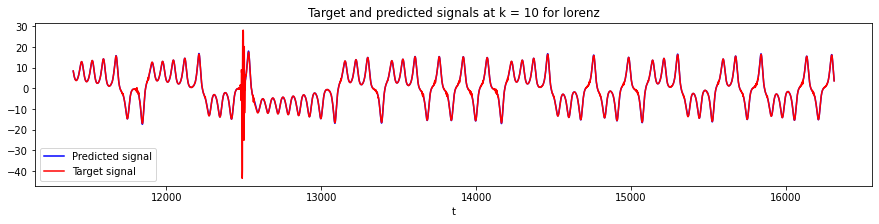

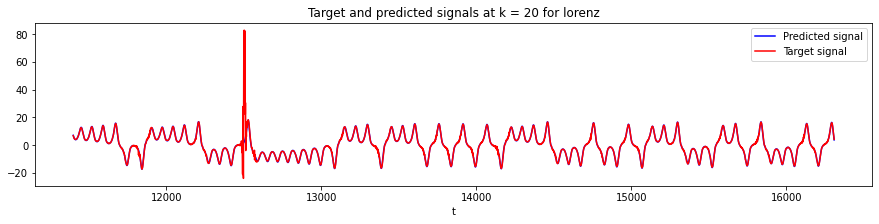

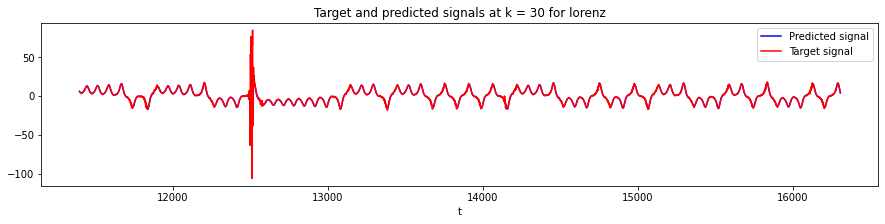

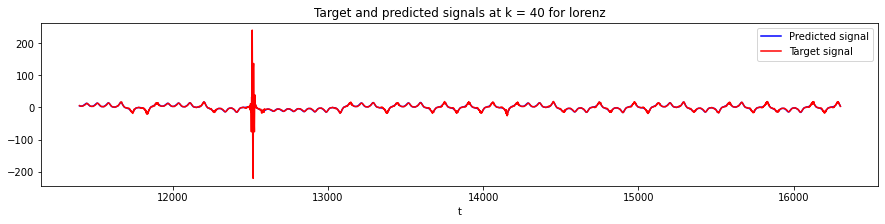

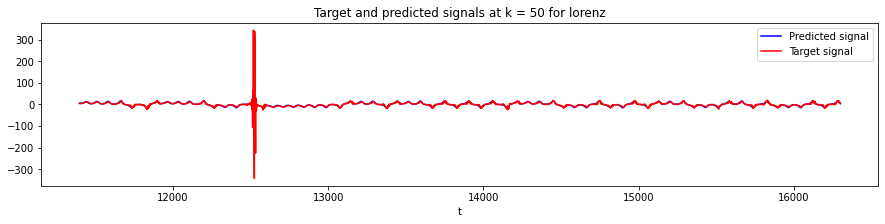

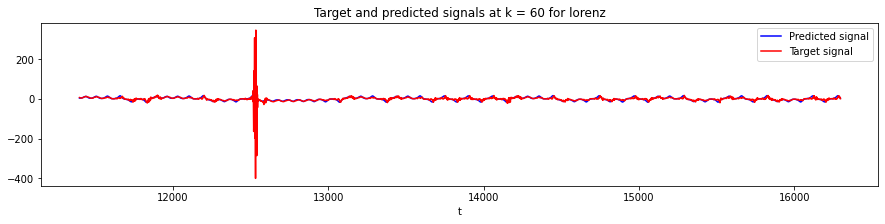

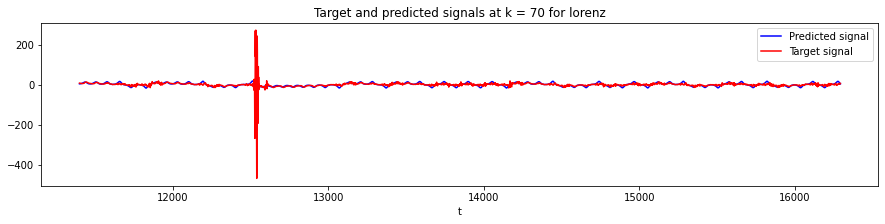

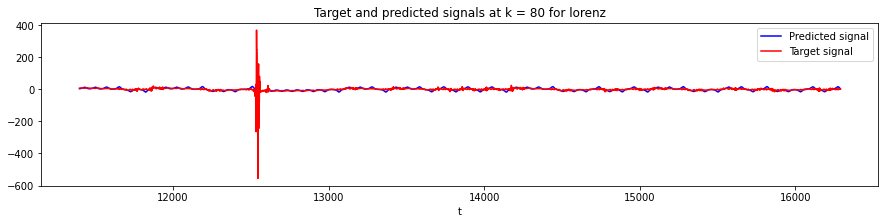

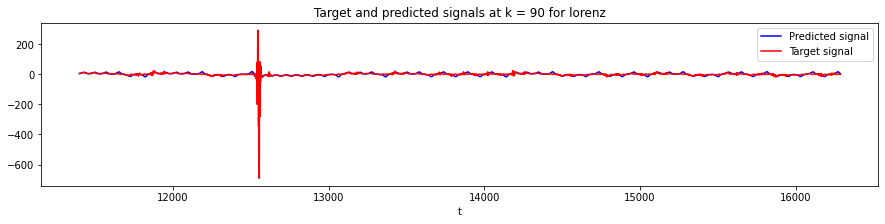

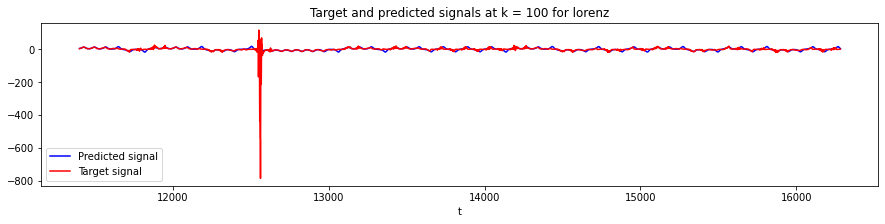

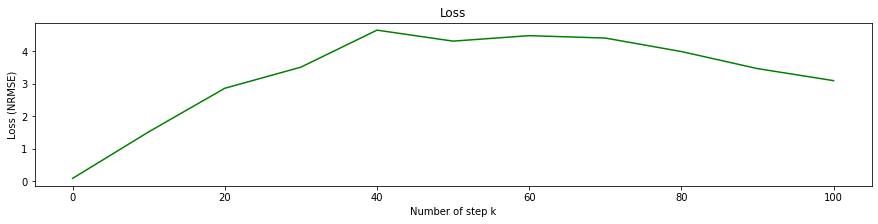

In [30]:
'''
Test our model on the lorenz data

'''
# Initialize an ESN model instance
model = ESN(reservoir_size = 500, input_dim = 1, random_seed = 33, a = 1.26, reg_cof = 1e-5)

# Run the model with different k for 2sin data, and collect results
for i in range(length):

    print('Computing model ', i)

    nrmse_result[i], z_result[i], target_result[i], time_start = predict_k_step(model, data2,\
                                                                                list_of_step_k[i],\
                                                                                training_part)

# plot some signals
plot_result(z_result, target_result, time_start, nrmse_result, list_of_step_k, 'lorenz')


reservoir_size = np.arange(300, 800, 100, dtype = int).tolist()   
reg_cof = [1e-1, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-3]                 
a = [0.80, 0.92, 1.06, 1.13, 1.26, 1.75, 3]
seed = 33

For lorenz: We see that as number of step increases, our reservoir size is to small and not be able to generate accurate prediction some certain time t> NRMSE seems to peak at k = 40

We will present 2 grids that show the NRMSE of each (forcasting horizon - reservoir size) combination

One of the grid use 2sin data, while the other examine on the lorenz data

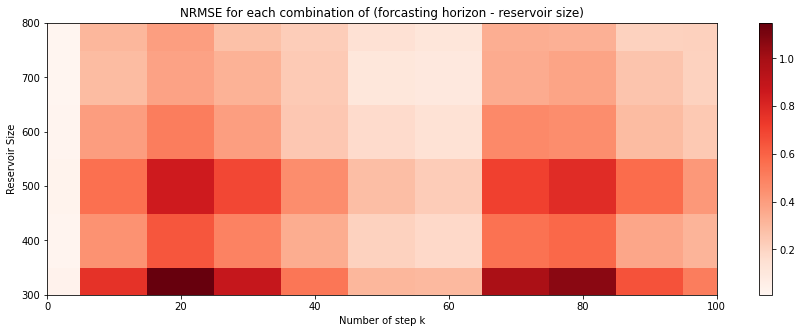

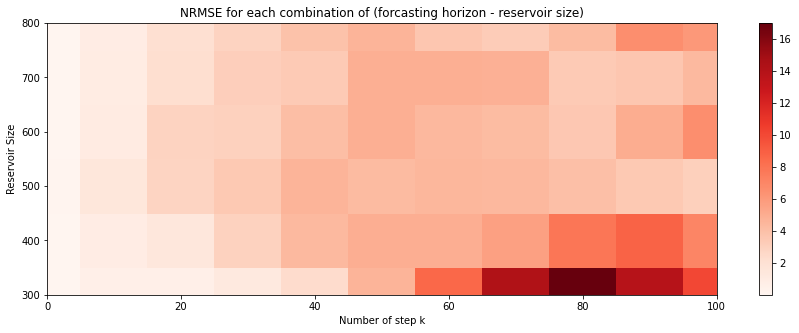

In [31]:
k_max = 100
step = 10
list_of_step_k = range(0, k_max+1, step)
training_part = 0.7
Xgrid = list_of_step_k                              # Forcasting horizon k
Ygrid = range(300, 801, 100)                        # Reservoir size
nrmse_result_2sin = np.empty( ( len(Ygrid), len(Xgrid), 1 ), dtype = float)
nrmse_result_lorenz = np.empty( ( len(Ygrid), len(Xgrid), 1 ), dtype = float)

for ny in range( len(Ygrid) ):
    for nx in range( len(Xgrid) ):
        
        model = ESN(reservoir_size = Ygrid[ny], input_dim = 1, random_seed = 33, a = 1.26, reg_cof = 1e-3)
        nrmse_result_2sin[ny, nx, 0], _, _, _ = predict_k_step(model, data1, Xgrid[nx], training_part)

for ny in range( len(Ygrid) ):
    for nx in range( len(Xgrid) ):
        
        model = ESN(reservoir_size = Ygrid[ny], input_dim = 1, random_seed = 33, a = 1.26, reg_cof = 1e-3)
        nrmse_result_lorenz[ny, nx, 0], _, _, _ = predict_k_step(model, data2, Xgrid[nx], training_part)


plt.figure(1, figsize = (15, 5))
plt.figure(1).clear()
plt .pcolor(Xgrid, Ygrid, nrmse_result_2sin[:,:,0], cmap="Reds", shading='auto')
plt.colorbar()
plt.axis((0, 100, 300, 800))
plt.title("NRMSE for each combination of (forcasting horizon - reservoir size)")
plt.xlabel('Number of step k')
plt.ylabel('Reservoir Size')

plt.figure(2, figsize = (15, 5))
plt.figure(2).clear()
plt .pcolor(Xgrid, Ygrid, nrmse_result_lorenz[:,:,0], cmap="Reds", shading='auto')
plt.colorbar()
plt.axis((0, 100, 300, 800))
plt.title("NRMSE for each combination of (forcasting horizon - reservoir size)")
plt.xlabel('Number of step k')
plt.ylabel('Reservoir Size')
plt.show()

We can see that at each forcasting horizon k, a larger reservoir size will lead to lower NRMSE in general. However, large reservoir size would also require more computational power.

$\boldsymbol{2sin\_data}$: We can see that the NRMSE is roughly at its largest at forcasting horizon k = 20 (given everything else are equal). This result coincide with the fit test we present above, where a model with reservoir size of 500 is used to predict several different forcasting horizon k, ranging from 10 to 100.

$\boldsymbol{lorenz\_data}$: The NRMSE seems to be highest at forcasting horizon k = 20, and the model performs poorly at this forcasting horizon (relative to others) if the reservoir size is too small (in this case the smallest is 300)

Next, we will see how different training data size affects nrmse

[0.3 0.4 0.5 0.6 0.7 0.8 0.9]
0.08066644950872547
1.30484812066415
2.179675589997419
1.9268873100120223
1.2223395506297532
0.6290423014238377
0.5583013648410793
1.728268544691835
2.0826322523990837
1.5015693188912347
0.9567409104749356
0.06238674906321332
1.0622425592732296
1.6602061388128588
1.4325020020461683
0.9550470187278552
0.5277469056224966
0.4469509703387557
1.3809335271004883
1.6272682354904109
1.1627413755723626
0.8032207576152407
0.047782617010861145
0.9298555985318281
1.3990131129754435
1.1214283742978362
0.7784016172401828
0.48167812861854475
0.4011703310863376
1.1823128379931918
1.2776905580231983
0.8924047013410327
0.7021278398544343
0.0379439588558758
0.7335782795552296
1.1000077555011267
0.8821329037411879
0.6067474592267472
0.40021505779268957
0.3244721435355511
0.9557222047088221
1.054060318873025
0.7618349100304882
0.5667283548943874
0.026303760534827733
0.5608591248169973
0.8544223690646896
0.6854855422955135
0.4569797319580209
0.28219656522380415
0.23010331818039

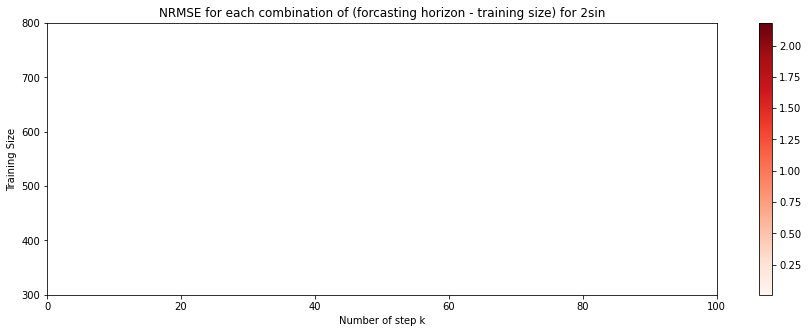

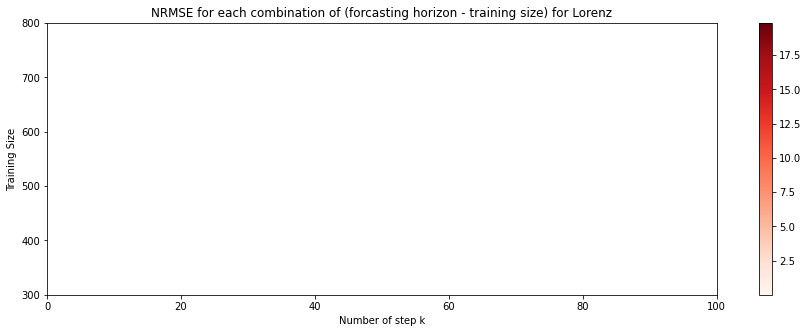

In [32]:
training_size_test = np.arange(0.3, 0.9, 0.1)
print(training_size_test)
Xgrid = list_of_step_k                           # Forcasting horizon k
Ygrid = training_size_test                       # training size

nrmse_result_2sin = np.empty( ( len(Ygrid), len(Xgrid), 1 ), dtype = float)
nrmse_result_lorenz = np.empty( ( len(Ygrid), len(Xgrid), 1 ), dtype = float)

for ny in range( len(Ygrid) ):
    for nx in range( len(Xgrid) ):
        
        model = ESN(reservoir_size = 500, input_dim = 1, random_seed = 33, a = 1.26, reg_cof = 1e-3)
        nrmse_result_2sin[ny, nx, 0], _, _, _ = predict_k_step(model, data1, Xgrid[nx], Ygrid[ny])

for ny in range( len(Ygrid) ):
    for nx in range( len(Xgrid) ):
        
        model = ESN(reservoir_size = 500, input_dim = 1, random_seed = 33, a = 1.26, reg_cof = 1e-3)
        nrmse_result_lorenz[ny, nx, 0], _, _, _ = predict_k_step(model, data2, Xgrid[nx], Ygrid[ny])


plt.figure(1, figsize = (15, 5))

plt.pcolor(Xgrid, Ygrid, nrmse_result_2sin[:,:,0], cmap="Reds", shading='auto')
plt.colorbar()
plt.axis((0, 100, 300, 800))
plt.title("NRMSE for each combination of (forcasting horizon - training size) for 2sin")
plt.xlabel('Number of step k')
plt.ylabel('Training Size')

plt.figure(2, figsize = (15, 5))

plt.pcolor(Xgrid, Ygrid, nrmse_result_lorenz[:,:,0], cmap="Reds", shading='auto')
plt.colorbar()
plt.axis((0, 100, 300, 800))
plt.title("NRMSE for each combination of (forcasting horizon - training size) for Lorenz")
plt.xlabel('Number of step k')
plt.ylabel('Training Size')
plt.show()

The printed values of NRMSE are very small. In general, the bigger the training data, the smaller the NRMSE. However, we will have less data to do our testing.